In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from utils.data_utils import DataLoader
import random
import os, yaml
from utils.env_utils import env_set
from datetime import datetime

In [ ]:
def read_cfg():
    
    with open('yaml/config.yaml') as f:
        cfg = yaml.load(f, Loader=yaml.FullLoader)

    with open(f"yaml/model/{cfg['model']['name']}.yaml") as f:
        model_cfg = yaml.load(f, Loader=yaml.FullLoader)
    
    for key, value in model_cfg.items():
        cfg['model'][key] = value

    with open(f"yaml/data/{cfg['data']}.yaml") as f:
        cfg.update(yaml.load(f, Loader=yaml.FullLoader))

    with open('yaml/aug.yaml') as f:
        cfg.update(yaml.load(f, Loader=yaml.FullLoader))

    # cfg['gpus'] = str(cfg['gpus'])
    cfg['gpus'] = ''

    cfg['model']['input_size'] = np.array(cfg['model']['input_size'])
    cfg['model']['strides'] = np.array(cfg['model']['strides'])
    cfg['model']['anchors'] = np.array(cfg['data']['anchors'][cfg['model']['anchors']]) * cfg['model']['input_size']

    cfg['model']['dir'] = f"{cfg['model']['dir']}/{cfg['data']['name']}/{cfg['model']['name']}"
    cfg['model']['train_checkpoint'] = f"{cfg['model']['dir']}/train_loss/{cfg['model']['name']}"
    cfg['model']['loss_checkpoint'] = f"{cfg['model']['dir']}/val_loss/{cfg['model']['name']}"
    cfg['model']['map_checkpoint'] = f"{cfg['model']['dir']}/val_mAP/{cfg['model']['name']}"
    cfg['model']['checkpoint'] = cfg['model'][cfg['model']['checkpoint']]

    cfg['eval']['dir'] = f"{cfg['eval']['dir']}/{cfg['data']['name']}/{cfg['model']['name']}"
    cfg['eval']['image_dir'] = f"{cfg['eval']['dir']}/image"
    cfg['eval']['video_dir'] = f"{cfg['eval']['dir']}/video"
    if 'soft' in cfg['eval']['nms']:
        cfg['eval']['score_th'] = 0.01
    else:
        cfg['eval']['score_th'] = 0.4    
        
    cfg['log']['dir'] = f"{cfg['log']['dir']}/{cfg['model']['name']}[{cfg['data']['name']}]_{datetime.now().strftime('%Y-%m-%d|%H:%M:%S')}"

    env_set(cfg)
    cfg['gpus'] = len(cfg['gpus'].split(','))
    cfg['batch_size'] *= cfg['gpus']
    # cfg['batch_size'] *= 4 if cfg['aug']['mosaic'] else 1

    return cfg

cfg = read_cfg()

In [ ]:
dataloader = DataLoader(cfg)
train_dataset = dataloader('train', cfg['batch_size'], aug=cfg['aug'])
val_dataset = dataloader('val')

data = []
for e in range(4):
    for i, (batch_images, batch_labels) in enumerate(train_dataset):
        
        if i==0:
            data += [[batch_images,batch_labels]]

In [ ]:
data

In [ ]:
"""
1. crop, resize_padding
2. mosaic 구현
3. rotate90, color_method, gaussian filter size 변경
4. 재현성 확인
"""
b=4
idx = 0
image =(data[b][0][idx].numpy()*255).astype(np.uint8)
labels = data[b][1]
labels = labels[labels[..., 0] == idx].numpy().astype(np.int32)

for i, x1, y1, x2, y2, c in labels:
    cv2.rectangle(image, [x1,y1], [x2,y2], [255, 0, 0], 2)
plt.imshow(image)
plt.show() 

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
image = np.array([np.zeros((150,3), np.float32)+i for i in range(256)])
labels = np.array([[20,30,80,170,0.]])

image_ = image.copy()
for x1, y1, x2, y2, c in labels.astype(np.int32):
    cv2.rectangle(image_, [x1,y1],[x2,y2], [255, 0,0], 2)
plt.imshow((image_).astype(np.uint8))
plt.show()

In [ ]:
def rotate90(iimage, llabels, seed=42):
    def rotate90_bboxes(lllabels, width, height):
        if tf.reduce_sum(lllabels) != 0:
            lllabels = tf.stack([lllabels[..., 1],
                                width - lllabels[..., 2] -1,
                                lllabels[..., 3],
                                width - lllabels[..., 0] -1,
                                lllabels[..., 4]], -1)
        return lllabels, height, width
    
    times = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32, seed=seed)
    size = tf.cast(tf.shape(iimage)[-2:-4:-1], tf.float32)
    width, height = size[0], size[1]
    for time in tf.range(times):
        size = tf.shape(iimage)[-2:-4:-1]
        llabels, width, height = rotate90_bboxes(llabels, width, height)
    return tf.image.rot90(iimage, times), tf.constant(llabels)
def resize(image, out_size):
    size = tf.cast(tf.shape(image)[-2:-4:-1], tf.float32)
    ratio = out_size/tf.reduce_max(size)
    new_size = tf.cast(ratio * size, tf.int32)
    resized_image = tf.image.resize(image, tf.cast(new_size, tf.int32)[::-1])
    mult = tf.stack([*tf.unstack(ratio),*tf.unstack(ratio),1.])

    return resized_image
image = cv2.imread('data/custom/train/JPEGImages/1.jpg').astype(np.float32)[..., ::-1]
image = resize(image, tf.stack([512.,512.]))
def gaussian_blur(imagei, labels, ksize=3, sigma=1, seed=42):
    idx = tf.random.uniform((), minval=0, maxval=6, dtype=tf.int32, seed=seed)
    ksize = [3, 5, 7, 9, 11, 13][idx]

    def gaussian_kernel(size=3, sigma=1):
        x_range = tf.range(-(size-1)//2, (size-1)//2 + 1, 1)
        y_range = tf.range((size-1)//2, -(size-1)//2 - 1, -1)

        xs, ys = tf.meshgrid(x_range, y_range)
        kernel = tf.exp(-(xs**2 + ys**2) / (2*(sigma**2))) / (2*np.pi*(sigma**2))
        return tf.cast(kernel / tf.reduce_sum(kernel), tf.float32)
    kernel = gaussian_kernel(ksize, sigma)[..., None, None]
    
    r, g, b = tf.split(imagei, [1,1,1], -1)
    r_blur = tf.nn.conv2d(r[None], kernel, [1,1,1,1], 'SAME')
    g_blur = tf.nn.conv2d(g[None], kernel, [1,1,1,1], 'SAME')
    b_blur = tf.nn.conv2d(b[None], kernel, [1,1,1,1], 'SAME')

    blur_image = tf.concat([r_blur, g_blur, b_blur], -1)[0]
    return blur_image, labels
image = image
image2, labels2 = gaussian_blur(tf.constant(image), tf.constant(labels), 13)
image_ = image2.numpy().copy()
labels2 = labels2.numpy()
for x1, y1, x2, y2, c in labels2.astype(np.int32):
    cv2.rectangle(image_, [x1,y1],[x2,y2], [255, 0,0], 2)
plt.imshow((image_).astype(np.uint8))
plt.show()

In [ ]:
image.shape

0.01

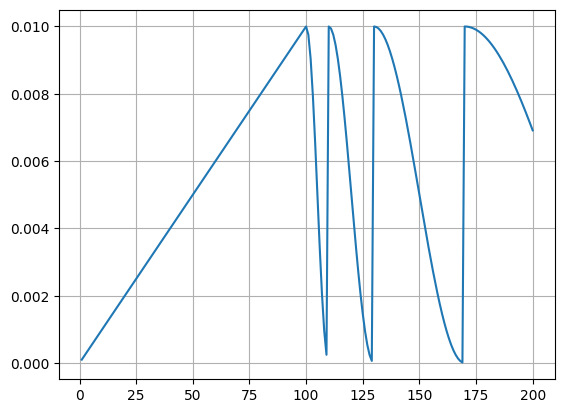

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
from utils.lr_utils import LR_scheduler

with open('yaml/config.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
cfg['train']['lr_scheduler']['name'] = 'cosine_annealing_warm_restart'
cfg['train']['lr_scheduler']['warmup_epochs']=1

epochs=2
step_per_epoch = 100
lr_scheduler = LR_scheduler(cfg['train']['lr_scheduler'], epochs, step_per_epoch)

steps = []
lrs = []
start_epoch = 1
step = (start_epoch-1)*step_per_epoch+1

for epoch in range(start_epoch, epochs+1):
    for _ in range(step_per_epoch):
        steps += [step]
        lrs += [lr_scheduler(step)]
        step += 1

plt.plot(steps, lrs)
plt.grid(True)
max(lrs)

In [ ]:
plt.plot(steps, t)
plt.grid(True)

In [ ]:
lrs[-1]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_annealing(t, min_lr, max_lr, t_max):
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(t / t_max * np.pi))

t_values = np.arange(0, 1000, 1)  # 학습 단계는 0부터 99까지
min_lr = 0.001  # 최소 학습률
max_lr = 0.01   # 최대 학습률
t_max = 50      # 주기

lr_values = cosine_annealing(t_values, min_lr, max_lr, t_max)

plt.plot(t_values, lr_values)
plt.xlabel('학습 단계 (t)')
plt.ylabel('학습률')
plt.title('Cosine Annealing Learning Rate Schedule')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_annealing(t, min_lr, max_lr, t_max):
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(t / t_max * np.pi))

t_values = np.arange(0, 300, 1)  # 학습 단계는 0부터 99까지
min_lr = 0.001  # 최소 학습률
max_lr = 0.01   # 최대 학습률
t_max = 50      # 초기 주기
t_max_increment = 0.00  # 주기 증가량

lr_values = []
for t in t_values:
    lr_values.append(cosine_annealing(t, min_lr, max_lr, t_max))
    if t % t_max == 0 and t != 0:
        t_max += t_max * t_max_increment  # 주기를 조금씩 증가시킴

plt.plot(t_values, lr_values)
plt.xlabel('학습 단계 (t)')
plt.ylabel('학습률')
plt.title('Cosine Annealing Learning Rate Schedule')
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf
from utils.aug_utils import resize_padding, resize, resize_padding_without_labels
import numpy as np
import cv2
import matplotlib.pyplot as plt

image = np.zeros((200,100,3), np.float32) + 128
labels = np.array([[20,70,50,100,0],[50,100,80,130,0]], np.float32)
image_ = image.astype(np.uint8)
for x1,y1,x2,y2,c in labels.astype(np.int32):
    cv2.rectangle(image_, [x1,y1], [x2,y2], [255, 0, 0], 2)
plt.imshow(image_)
plt.show()

In [ ]:
imager, labelsr = resize_padding_without_labels(image, tf.constant([512, 512], tf.float32))
image_ = imager.numpy().astype(np.uint8)
# for x1,y1,x2,y2,c in labelsr.numpy().astype(np.int32):
#     cv2.rectangle(image_, [x1,y1], [x2,y2], [255, 0, 0], 2)
plt.imshow(image_)
plt.show()

In [ ]:
def crop(image, labels, xyxy=None, seed=42):
    if xyxy is None:
        size = tf.cast(tf.shape(image)[-2:-4:-1], tf.float32)
        x1, y1 = tf.unstack(tf.cast(tf.random.uniform([2], minval=[0,0], maxval=size//3, seed=seed), tf.int32))
        x2, y2 = tf.unstack(tf.cast(tf.random.uniform([2], minval=size//3*2, maxval=size, seed=seed), tf.int32))
    else:
        x1, y1, x2, y2 = tf.unstack(xyxy)
    
    crop_image = image[y1:y2, x1:x2]
    flag = tf.logical_and(tf.reduce_all(labelsr[..., 2:4] > [x1, y1], -1),
                           tf.reduce_all(labelsr[..., :2] < [x2, y2], -1))
    filtered_labels = labels[flag]
    crop_labels = tf.concat([tf.maximum(filtered_labels[..., :2] - [x1, y1], 0),
                             filtered_labels[..., 2:4] - [x1, y1] - tf.maximum(filtered_labels[..., 2:4] - [x2, y2], 0),
                             filtered_labels[..., 4:]], -1)
    return crop_image, crop_labels

In [ ]:
xyxy = np.array([100, 50, 300, 150])
imagec, labelsc = crop(image_, labelsr)
imagecc = imagec.astype(np.uint8)
for x1, y1, x2, y2, c in labelsc.numpy().astype(np.int32):
    cv2.rectangle(imagecc, [x1,y1], [x2,y2], [0, 0, 255], 1)
plt.imshow(imagecc)
plt.show()

In [ ]:
imager[y1:y2, x1:x2].shape

In [ ]:

image_ = imagec.astype(np.uint8)
plt.imshow(image_)
plt.show()

In [ ]:
import time
import tensorflow as tf
q=tf.constant([1])

In [ ]:
f = tf.zeros([3,5], tf.float32)
st=time.time()
d=[]
for idx in range(10):
    b=[]
    for _ in range(3):
        a=f[i]
        b+=[a]
c=tf.concat([b],0)
d += [tf.concat([tf.zeros(c.shape[:-1], dtype=tf.float32)[..., None]+idx, c], -1)]

time.time()-st, tf.concat(d, 0).shape

In [ ]:
f = tf.zeros([3,5], tf.float32)
st=time.time()
d=[]
for idx in range(10):
    b=[]
    for i in range(3):
        a=f[i]
        b+=[tf.concat([tf.zeros(a.shape[:-1], dtype=tf.float32)[..., None]+idx, a], -1)]
c=tf.concat([b],0)
d += [c]

time.time()-st, tf.concat(d, 0).shape

In [ ]:
import numpy as np

In [ ]:
a = np.array([512., 512.])
b = np.round(a*1.2)
c = np.round((b-512)/2)
c, a+c